Predict emotions from emodb with a multi layer perceptron

In [1]:
import audformat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import opensmile
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score

/home/felix/data/envs/researchEnv/lib/python3.8/site-packages/opensmile/core/single.py:74: UserWarning: 'ignore_vars' argument is deprecated and will be removed with version 0.5.0. Use 'hide' instead.
  @audobject.init_decorator(
/home/felix/data/envs/researchEnv/lib/python3.8/site-packages/opensmile/core/multi.py:45: UserWarning: 'ignore_vars' argument is deprecated and will be removed with version 0.5.0. Use 'hide' instead.
  @audobject.init_decorator(


In [2]:
# get and unpack the Berlin Emodb emotional database if not already there
if not os.path.isdir('./emodb/'):
    !wget -c https://tubcloud.tu-berlin.de/s/LzPWz83Fjneb6SP/download
    !mv download emodb_audformat.zip
    !unzip emodb_audformat.zip
    !rm emodb_audformat.zip
# prepare the dataframe
db = audformat.Database.load('./emodb')
root = './emodb/'
db.map_files(lambda x: os.path.join(root, x))    
df_emotion = db.tables['emotion'].df
df = db.tables['files'].df
# copy the emotion label from the the emotion dataframe to the files dataframe
df['emotion'] = df_emotion['emotion']

In [3]:
# Encode the emotion words as numbers and use this as target 
target = 'enc_emo'
encoder = LabelEncoder()
encoder.fit(df['emotion'])
df[target] = encoder.transform(df['emotion'])

In [4]:
df.head()

,duration,speaker,transcription,emotion,enc_emo
file,,,,,
./emodb/wav/03a01Fa.wav,0 days 00:00:01.898250,3,a01,happiness,4
./emodb/wav/03a01Nc.wav,0 days 00:00:01.611250,3,a01,neutral,5
./emodb/wav/03a01Wa.wav,0 days 00:00:01.877812500,3,a01,anger,0
./emodb/wav/03a02Fc.wav,0 days 00:00:02.006250,3,a02,happiness,4
./emodb/wav/03a02Nc.wav,0 days 00:00:01.439812500,3,a02,neutral,5


In [6]:
df.speaker.unique()

[3, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Categories (10, object): [3, 8, 9, 10, ..., 13, 14, 15, 16]

In [7]:
train_spkrs

[12, 13, 14, 15, 16]
Categories (10, object): [3, 8, 9, 10, ..., 13, 14, 15, 16]

In [4]:
# define fixed speaker disjunct train and test sets
train_spkrs = df.speaker.unique()[5:]
test_spkrs = df.speaker.unique()[:5]
df_train = df[df.speaker.isin(train_spkrs)]
df_test = df[df.speaker.isin(test_spkrs)]

print(f'#train samples: {df_train.shape[0]}, #test samples: {df_test.shape[0]}')

#train samples: 292, #test samples: 243


In [5]:
# extract (or get) GeMAPS features
if os.path.isfile('feats_train.pkl'):
    feats_train = pd.read_pickle('feats_train.pkl')
    feats_test = pd.read_pickle('feats_test.pkl')
else:
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.GeMAPSv01b,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    feats_train = smile.process_files(df_train.index)
    feats_test = smile.process_files(df_test.index)
    feats_train.to_pickle('feats_train.pkl')
    feats_test.to_pickle('feats_test.pkl')

In [10]:
feats_train.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
file,start,end,,,,,,,,,,,,,,,,,,,,,
./emodb/wav/12a01Fb.wav,0 days,0 days 00:00:01.863625,28.289259,0.116709,27.115950,28.501019,30.654314,3.538364,21.160583,14.500553,160.898361,122.293381,...,-6.833267,16.022577,0.005844,0.009621,4.864865,3.888889,0.128571,0.081316,0.105714,0.059966
./emodb/wav/12a01Lb.wav,0 days,0 days 00:00:01.886562500,27.945791,0.106348,24.263607,28.366644,30.950678,6.687071,11.931705,4.881357,33.164783,8.243453,...,-8.385858,19.961433,-0.008345,0.005213,5.882353,2.747253,0.124000,0.058856,0.181667,0.210033
./emodb/wav/12a01Nb.wav,0 days,0 days 00:00:01.721937500,27.633751,0.109995,24.785194,28.274734,30.643663,5.858469,81.267586,64.092369,1.411703,26.013653,...,-6.468753,14.270401,-0.007007,0.001905,6.432749,3.012048,0.160000,0.101193,0.125000,0.079739
./emodb/wav/12a01Wc.wav,0 days,0 days 00:00:02.358812500,34.412128,0.103001,31.290031,34.217758,36.587021,5.296989,47.767605,35.979683,136.609329,94.123871,...,-2.473998,13.763072,0.008928,0.018180,3.846154,2.620087,0.213333,0.091043,0.125714,0.061146
./emodb/wav/12a02Ac.wav,0 days,0 days 00:00:01.225500,32.031712,0.097236,29.757168,31.876709,34.563087,4.805920,84.312378,34.235596,9.967800,42.942818,...,-7.574747,18.054522,-0.018632,0.002766,6.611571,5.172414,0.080000,0.048990,0.078571,0.029966


In [6]:
# Perform a standard scaling / z-transformation on the features (mean=0, std=1)
scaler = StandardScaler()
scaler.fit(feats_train)
feats_train_norm = pd.DataFrame(scaler.transform(feats_train))
feats_test_norm = pd.DataFrame(scaler.transform(feats_test))

In [15]:
feats_test.head(10)

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
file,start,end,,,,,,,,,,,,,,,,,,,,,
./emodb/wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,31.188164,0.152560,27.766502,31.412094,36.340340,8.573837,34.608944,11.036857,91.834778,43.389191,...,-5.667033,16.151026,-0.012351,0.010897,4.255319,3.278689,0.156667,0.084591,0.108571,0.036422
./emodb/wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,25.022936,0.148540,20.637062,25.118475,28.660351,8.023289,54.014923,38.583805,27.074680,0.593055,...,-10.316612,21.662098,-0.020058,0.007849,6.250000,3.870968,0.101667,0.055202,0.115714,0.049816
./emodb/wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,34.292316,0.102067,30.504087,33.584766,37.343616,6.839529,35.548046,5.873606,5.734793,25.473360,...,-0.997987,12.385583,0.014669,0.012394,4.838710,3.314917,0.150000,0.073030,0.111429,0.060339
./emodb/wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,37.576569,0.108607,34.083500,37.371193,41.233376,7.149876,30.146027,14.919353,38.302841,20.924088,...,-5.103197,15.929288,-0.007576,0.015585,4.522613,2.577320,0.246000,0.210960,0.100000,0.042032
./emodb/wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,25.040188,0.116655,21.225208,26.198664,27.725220,6.500011,19.461372,10.744597,27.572823,6.934999,...,-13.272980,23.824095,-0.035085,0.005547,6.338028,3.649635,0.148000,0.130138,0.086667,0.026247
./emodb/wav/03a02Ta.wav,0 days,0 days 00:00:01.735687500,23.199287,0.063191,21.326691,23.556671,24.742411,3.415720,14.027404,8.320529,15.265544,7.346774,...,-6.580761,15.852320,-0.020736,0.002862,6.395349,2.994012,0.114000,0.064374,0.165000,0.126590
./emodb/wav/03a02Wb.wav,0 days,0 days 00:00:02.123625,34.944218,0.113250,31.575916,34.201447,39.749702,8.173786,48.505169,1.378333,38.760056,23.643639,...,-5.026937,15.705659,-0.001637,0.017282,5.687204,4.368932,0.111111,0.060817,0.120000,0.026726
./emodb/wav/03a02Wc.wav,0 days,0 days 00:00:01.498062500,38.265858,0.100074,34.468632,39.165150,41.601871,7.133240,29.926332,19.864269,39.025867,8.647630,...,-6.030575,16.919962,0.018910,0.015370,5.405406,4.195804,0.135000,0.088647,0.070000,0.031623
./emodb/wav/03a04Ad.wav,0 days,0 days 00:00:01.504874999,37.341007,0.052692,36.079861,37.437683,39.032368,2.952507,181.882019,153.923080,21.611544,5.935982,...,-2.956374,13.420055,0.009788,0.008622,4.026845,5.555556,0.096250,0.050234,0.055556,0.026713


In [14]:
feats_test_norm.head(10)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,-0.527572,0.560709,-0.592238,-0.493766,-0.124357,1.112909,-0.517225,-0.559794,0.226678,-0.134685,...,0.465072,-0.261772,-0.004763,0.321502,-0.688453,0.048532,-0.466851,-0.765996,-0.008088,-0.585104
1,-1.539893,0.490142,-1.730940,-1.484866,-1.320774,0.902338,-0.378098,-0.384922,-0.315948,-0.431179,...,-0.436951,0.738752,-0.384108,-0.211428,1.522220,0.776942,-1.222573,-1.158467,0.128005,-0.392545
2,-0.017875,-0.325831,-0.154996,-0.151620,0.031937,0.449578,-0.510492,-0.592571,-0.494755,-0.258807,...,1.370872,-0.945381,1.325281,0.583365,-0.041891,0.093088,-0.558454,-0.920384,0.046349,-0.241263
3,0.521394,-0.211015,0.416702,0.444655,0.637898,0.568278,-0.549221,-0.535147,-0.221867,-0.290324,...,0.574457,-0.302028,0.230259,1.141262,-0.392215,-0.814042,0.760624,0.921590,-0.171400,-0.504452
4,-1.537060,-0.069705,-1.637002,-1.314761,-1.466452,0.319721,-0.625823,-0.561649,-0.311774,-0.387242,...,-1.010489,1.131259,-1.123841,-0.613944,1.619780,0.504738,-0.585935,-0.157731,-0.425440,-0.731378
5,-1.839333,-1.008424,-1.620794,-1.730814,-1.931125,-0.859946,-0.664780,-0.577038,-0.414897,-0.384389,...,0.287808,-0.316002,-0.417487,-1.083361,1.683307,-0.301575,-1.053108,-1.035977,1.067047,0.711159
6,0.089166,-0.129490,0.016195,-0.054507,0.406766,0.959899,-0.417599,-0.621108,-0.218036,-0.271483,...,0.589252,-0.342628,0.522628,1.437907,0.898481,1.389360,-1.092803,-1.083471,0.209661,-0.724486
7,0.634574,-0.360836,0.478214,0.727162,0.695304,0.561915,-0.550796,-0.503756,-0.215809,-0.375376,...,0.394545,-0.122173,1.534046,1.103632,0.586169,1.176440,-0.764560,-0.711821,-0.742990,-0.654091
8,0.482715,-1.192763,0.735557,0.455126,0.295017,-1.037114,0.538622,0.347267,-0.361724,-0.394163,...,0.990943,-0.757574,1.085008,-0.076260,-0.941666,2.848720,-1.297000,-1.224809,-1.018201,-0.724675
9,-0.081963,0.478336,-0.593468,0.201481,0.015982,1.460409,0.054218,-0.085453,-0.185717,-0.126150,...,0.196820,-0.226709,0.339966,0.383169,-1.446397,2.052299,-1.211123,-0.971034,-0.721820,-0.710968


In [7]:
def get_loader(df_x, df_y):
    data=[]
    for i in range(len(df_x)):
       data.append([df_x.values[i], df_y[target][i]])
    return torch.utils.data.DataLoader(data, shuffle=True, batch_size=8)
trainloader = get_loader(feats_train_norm, df_train)
testloader = get_loader(feats_test_norm, df_test)

In [19]:
feats_train_norm.shape[1]

62

In [22]:
encoder.classes_

array(['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral',
       'sadness'], dtype=object)

In [8]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(feats_train_norm.shape[1], 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, len(encoder.classes_))
        )
    def forward(self, x):
        # x: (batch_size, channels, samples)
        x = x.squeeze(dim=1)
        return self.linear(x)

In [9]:
def train_epoch(model, loader, device, optimizer, criterion):
    model.train()
    losses = []
    for features, labels in loader:
        logits = model(features.to(device))
        loss = criterion(logits, labels.to(device))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return (np.asarray(losses)).mean()

def evaluate_model(model, loader, device, encoder):
    logits = torch.zeros(len(loader.dataset), len(encoder.classes_))
    targets = torch.zeros(len(loader.dataset))
    model.eval()
    with torch.no_grad():
        for index, (features, labels) in enumerate(loader):
            start_index = index * loader.batch_size
            end_index = (index + 1) * loader.batch_size
            if end_index > len(loader.dataset):
                end_index = len(loader.dataset)
            logits[start_index:end_index, :] = model(features.to(device))
            targets[start_index:end_index] = labels

    predictions = logits.argmax(dim=1)
    uar = recall_score(targets.numpy(), predictions.numpy(), average='macro')
    return uar, predictions, targets

In [18]:
device = 'cpu'
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epoch_num = 250
uars_train = []
uars_dev = []
losses = []

In [19]:
for epoch in range(0, epoch_num):
    loss = train_epoch(model, trainloader, device, optimizer, criterion)
    losses.append(loss)
    acc_train = evaluate_model(model, trainloader, device, encoder)[0]
    uars_train.append(acc_train)
    acc_dev, preds, truths = evaluate_model(model, testloader, device, encoder)
    uars_dev.append(acc_dev)
# scale the losses so they fit on the picture
losses = np.asarray(losses)/2

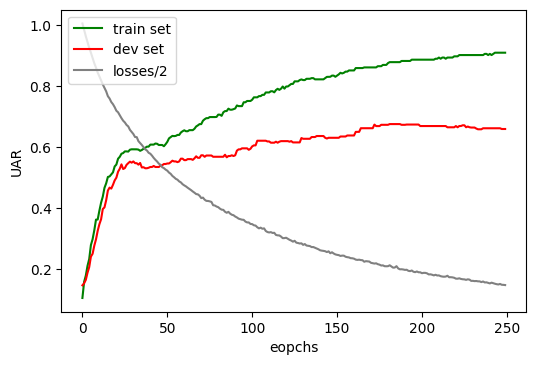

In [20]:
plt.figure(dpi=100)
plt.plot(uars_train, 'green', label='train set') 
plt.plot(uars_dev, 'red', label='dev set')
plt.plot(losses, 'grey', label='losses/2')
plt.xlabel('eopchs')
plt.ylabel('UAR')
plt.legend()
plt.show()

In [15]:
encoder.

array(['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral',
       'sadness'], dtype=object)

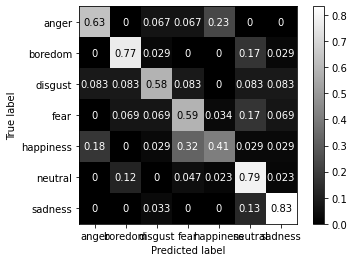

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truths, preds,  normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_).plot(cmap='gray')